<a href="https://colab.research.google.com/github/NeurKnight/codeforusing/blob/main/DeepSafari2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img height="60px" src="https://colab.research.google.com/img/colab_favicon.ico" align="left" hspace="20px" vspace="5px">

## A Safari of Deep Learning Procedures
For Beginners & Intermediate Practitioners
<br>To navigate, simply click on a cell and hit **Shift + Enter**.


## Working With Colaboratory

### Why Colaboratory? What's it good for?

Colaboratory is effectively a 'virtual machine' powered by Google's cloud computing resources that requires no installation and no money. And sometimes (when Google's feeling benevolent) it even allows you to use a fancy graphics processing unit (or even fancier tensor processing unit) to power some basic deep learning.


### Interacting with Colaboratory

**By Code or By Interface**: A sweet feature of Colaboratory is its neat take on interactivity -- called 'forms' -- which allows you to create graphical interfaces on the fly. You'll increasingly see this in various online tutorials, and we'll even use a few of them today. If, at any time, you want to see the code behind the interface, simply click **Edit → Show/Hide Code** on the relevant cell.

When first you access this notebook, it's likely you'll be able only to view it.

To edit and more freely interact with the notebook, navigate to **File → Save a Copy in Drive**

The following cell creates a graph with some variables you can change.


*   **NumberOfPoints**: The number of data points to be plotted.
*   **Polynomial:** How much you allow your fitted line to 'bend' to fit the data. Input a value of 1 and the line will be perfectly straight.
*  **Variance**: How 'spread out' the data points will be. Higher values mean greater spread.
* **Colors**: Choose some colors for your data points and fitted line. [Here](https://matplotlib.org/mpl_examples/color/named_colors.png) are your options.

Once you've set the parameters to your desired values, simply click **Shift + Enter** to generate the graph.

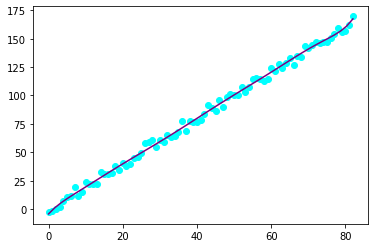

In [ ]:
#@title Graphical Parameters

NumberOfPoints = 83 #@param {type:"slider", min:0, max:100, step:1}
Polynomial = 9 #@param {type:"slider", min:1, max:10, step:1}
Variance = 6 #@param {type:"slider", min:0, max:100, step:1}
DotColor = 'Cyan' #@param {type:"string"}
LineColor = 'Purple' #@param {type:"string"}

#import the prerequisite libraries
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import random

#define the x and y vectors
x = np.arange(NumberOfPoints)
y = [x_i + random.uniform(x_i-Variance, x_i+Variance) for x_i in x]

# calculate polynomial
z = np.polyfit(x, y, Polynomial)
f = np.poly1d(z)

# calculate the points through which the line will cross
x_new = np.linspace(x[0], x[-1], 50)
y_new = f(x_new)


plt.plot(x,y,'o', color = DotColor)
plt.plot(x_new, y_new, color = LineColor)
ax = plt.gca()
fig = plt.gcf()

In [ ]:
#@title Random Sequence Generator (the Fisher-Yates Shuffle)

NumberOfElements = 12 #@param {type:"slider", min:0, max:25, step:1}

from random import shuffle
x = [i for i in range(1,NumberOfElements+1)]
shuffle(x)
print(x)

[11, 6, 10, 1, 3, 9, 5, 12, 7, 2, 8, 4]


### Release the Power of the GPU!

Before running the cells below, be sure to adjust the notebook settings such that you're taking advantage of Colab's hardware acceleration (which we'll need for the deep learning component of this tutorial). To do so, navigate to **Runtime > Change Runtime Type** and under **Hardware accelerator** change the dropdown such that it says **GPU** or **TPU**. Once you've changed the runtime type, your notebook settings should appear as follows.

<img height="300px" src="https://www.kdnuggets.com/wp-content/uploads/colab-settings-1.png" vspace='10px' hspace='10px'>


## Deep Learning on Image Data

The real juice of deep learning (and arguably the reason we're currently experiencing a renaissance of artificial intelligence research) is because until about six years ago, every introduction to psychology class began by saying: 'computers can't even properly recognize objects from two different angles'.

Now, they can. And almost spectacularly so.

Here, we'll fit a deep neural network to recognize objects in images.

### Transfer Learning with fast.ai

With the incredible proliferation of open-source infrastructure for deep learning has come also a wealth of pretrained models, sometimes trained using hardcore hardware not available to the layperson. Because of the wide availability of these models, it's almost never the case that you'll want to attempt image classification from a randomly initialized model. (In those cases where you do, it's likely because you have an image database whose statistics don't map neatly onto those of natural images).

The name of the game, then, is transfer learning, of which there are two versions: fixed feature extraction (where you keep all weights of the network constant except for those of the classifier) and finetuning (where you allow the pretrained weights of the network to be modulated by the new task).

The deep learning framework we'll be using to transfer learn on image data is a framework called [fast.ai](https://www.fast.ai/), an ecosystem of code and free courses whose brand is 'making neural nets uncool again'. fast.ai abstracts away from many of the nitty gritty engineering tasks that accompany deep learning, and provides a set of streamlined, effective tools that facilitate the building of competitively performant models.

Importantly, though, it's all built on top of PyTorch -- meaning the models you train are at their core PyTorch models that can be extracted and manipulated via pure PyTorch at will.

In [ ]:
!pip uninstall -q -y torchtext && pip install -q fastai==1.0.61 torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2

     |████████████████████████████████| 239 kB 10.3 MB/s 
     |████████████████████████████████| 776.8 MB 17 kB/s 
     |████████████████████████████████| 12.8 MB 55.7 MB/s 
     |████████████████████████████████| 7.6 MB 62.3 MB/s 
     |████████████████████████████████| 355 kB 75.4 MB/s 


In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate

In [ ]:
import fastai
fastai.__version__

'1.0.61'

### The Shape Central Dataset

The dataset you just downloaded is a dataset I made in Blender, a 3D animation interface. (If you want to have a look at the generative code, feel free to check out this Github [page](https://github.com/ColinConwell/ShapeCentral).)

It consists of simple objects viewed under a number of variable viewing conditions. Those variables are as follows:


*   Position
*   Rotation
*   Texture

The last of these variables is meant to deliberately foil a very common technique deep networks use to recognize objects; specifically, to identify small, but highly discriminative patches of pixels that given the statistical contingencies of large datasets, sometimes seperate one object from another by chance alone!

(Remember the apocryphal allegory of the Russian versus American tanks).

In [ ]:
!gdown https://drive.google.com/uc?id=10WzhgUaRRZMQ9rm020ApZHhq6GvNLZoe
!tar xfj simple_shapes.bz2

Downloading...
From: https://drive.google.com/uc?id=10WzhgUaRRZMQ9rm020ApZHhq6GvNLZoe
To: /content/simple_shapes.bz2
100% 28.3M/28.3M [00:00<00:00, 82.6MB/s]


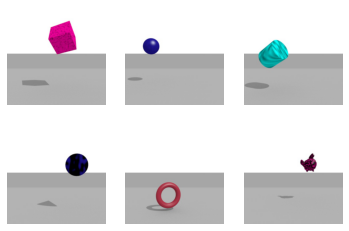

In [ ]:
images = [plt.imread(f"SimpleShapes/00001{i}.jpg") for i in ['Cube', 'Sphere', 'Cylinder', 'Cone', 'Torus', 'Suzanne']]

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True)

for img, ax in zip(images, axes.flat):
    ax.imshow(img)
    ax.axis('off')

Notice some of these are harder than others: Here is a cone that is distinguishable from a sphere only by its shadow.

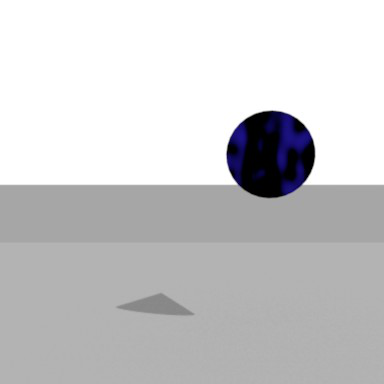

In [ ]:
open_image('SimpleShapes/00001Cone.jpg')

### Dataset Preparation

Our first step with a dataset of this sort is to create a dataframe with the paths to all the data files (in this case, the images) and a label associated with that data file (in this case, the identity of the object in the image).

In [ ]:
image_path = 'SimpleShapes'
assets = glob(f'{image_path}/*.jpg') # glob all our image files

dictlist = [] # running list of rows
for asset in assets:

    # loop through the filenames and extract
    # indices and labels:
    imgstr = asset.split('/')[1]
    index = imgstr[:5]
    item = imgstr[5:imgstr.rfind('.')]

    # add these to a dictionary:
    row = {'image_name': imgstr, 'image_index': index, 'label': item}

    # append dictionary to running list of rows
    dictlist.append(row)

# create a dataframe from our list of
label_df = pd.DataFrame(dictlist)

Our completed labels dataframe should appear as follows:

In [ ]:
label_df.sample(10).head()

,image_name,image_index,label
5796,00131Cylinder.jpg,00131,Cylinder
2749,00721Suzanne.jpg,00721,Suzanne
2683,00600Torus.jpg,00600,Torus
4507,00301Cylinder.jpg,00301,Cylinder
2316,00037Cone.jpg,00037,Cone


### Training & Test Splits

A generally good idea with any machine learning experiment is to some sort of a unique identifier (read: very long string) that you can use to save the various files associated with the experiment (the final model weights, for example).

This one long string should consist of all the variables that define how your model will be trained -- things like the dataset used, the number of items to use for training and test, and how many iterations to run when training the model. (Alternatively, you can use model training infrastructure like the increasingly popular [Weights & Biases](https://wandb.ai/).


In [ ]:
experiment = {'trainData': 'SimpleShapes',
              'testData': 'SimpleShapes',
              'subset': 'Stack_3',
              'model': 'resnet34',
              'finetuning': False,
              'nEpochs': 3,
              'trainSetSize': 800,
              'valSetSize': 200}
'_'.join('{}_{}'.format(key, val) for key, val in experiment.items())

'trainData_SimpleShapes_testData_SimpleShapes_subset_Stack_3_model_resnet34_finetuning_False_nEpochs_3_trainSetSize_800_valSetSize_200'

We can use fastai's functionality to split our data into training and test sets, or we could use something like scikit-learn to double check we're passing an even amount of data from each category. (This can help prevent the network from monopolizing a bias in the label quantities).

In [ ]:
from sklearn.model_selection import train_test_split

# save all our target dataset sizes
train_size = experiment['trainSetSize']
eval_size = experiment['valSetSize']
total_size = train_size + eval_size

# split the indices in our dataset into training and test
all_indices = list(range(1, train_size + eval_size))
test_indices = train_test_split(all_indices, test_size = eval_size)[1]
label_df['val_set'] = pd.to_numeric(label_df['image_index']).isin(test_indices)

# confirm our splitting produced even quantities
print('Proportion of Labels in Training / Eval')
print(label_df.groupby(['val_set'])['label'].value_counts())

Proportion of Labels in Training / Eval
val_set  label   
False    Cone        800
         Cube        800
         Cylinder    800
         Sphere      800
         Suzanne     800
         Torus       800
True     Cone        200
         Cube        200
         Cylinder    200
         Sphere      200
         Suzanne     200
         Torus       200
Name: label, dtype: int64


In [ ]:
# create a dataloader from our dataframe
data = (ImageList.from_df(label_df, Path(image_path), cols='image_name') # specify the column with the image names
                   .split_from_df(col='val_set') # specify the column that splits the training / val sets
                   .label_from_df(cols='label') # specify the column containing the labels
                   .transform(get_transforms(), size=224) # apply a resize transform
                   .databunch(bs=48)).normalize(imagenet_stats) # define batch size and normalize with imagenet statistics

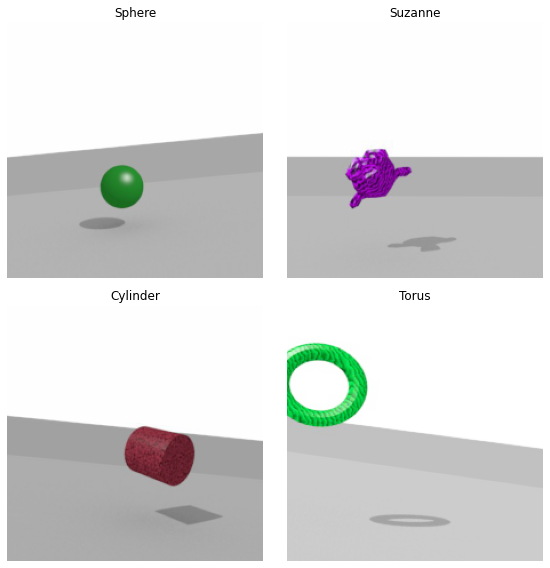

In [ ]:
data.show_batch(2)

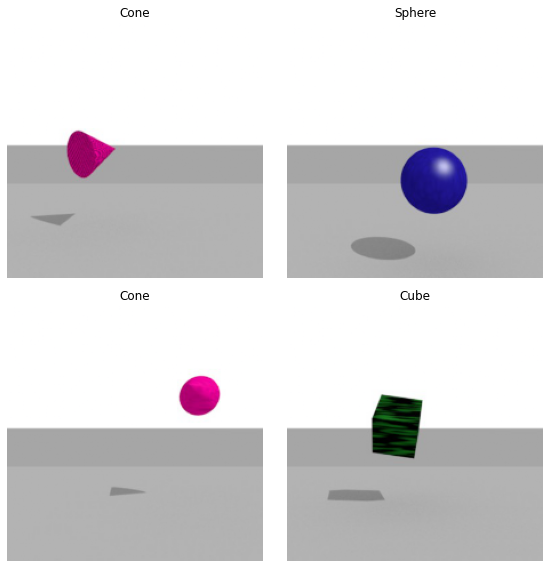

In [ ]:
data.show_batch(2, ds_type = 'Valid')

### Model Training

When it comes to pretrained models, we have quite a few options. Some of the most popular are those in the [torchvision model zoo](https://pytorch.org/vision/0.8/models.html), though perhaps the best models these days come from Ross Wrightmann's [pytorch-image-models](https://github.com/rwightman/pytorch-image-models) repository.

Having defined our data and using fastai's wizardry, we can define and train our model in four lines of code.

In [ ]:
learner = cnn_learner(data, models.resnet18,  metrics=accuracy)
# this is our learner object; it contains our model and various training functions

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Important to remember is that the default setting in fixed feature extraction is one where all weights of the network are frozen except for those of the batch normalization layers -- which fastai allows to be modulated since they help capture the statistics of the data currently being processed without changing other features like convolutional filters we wish to remain static. We can see this freezing of layers in the model summary below:

In [ ]:
# If you opted for finetuning in this experiment, we can unfreeze the network as follows:
if experiment['finetuning']:
    learner.unfreeze();

In [ ]:
# Here's a detailed summary of what our model now looks like:
learner.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 112, 112]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 112, 112]       128        True      
______________________________________________________________________
ReLU                 [64, 112, 112]       0          False     
______________________________________________________________________
MaxPool2d            [64, 56, 56]         0          False     
______________________________________________________________________
Conv2d               [64, 56, 56]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 56, 56]         128        True      
______________________________________________________________________
ReLU                 [64, 56, 56]         0          False     
___________________________________________________

The following function attempts to find an optimal learning rate with which to train our model.

In [ ]:
learner.lr_find();

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


(Generally speaking, we want to select the learning rate at the valley as "the maximum learning rate").

After setting our maximum learning rate, we use a training regime called the "one cycle policy" to fit our model. The one cycle policy gradually elevates, then lowers the training rate across epochs -- in a process that is at least conceptually similiar to simulated annealing (a technique for finding the global minimum of a function by cycling through 'hot' and 'cold' phases of learning).

Min numerical gradient: 3.02E-03
Min loss divided by 10: 1.74E-02


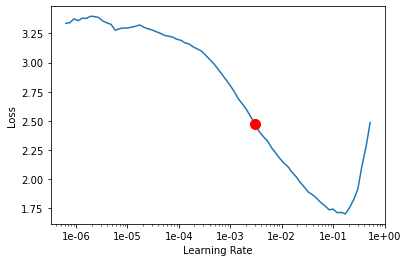

In [ ]:
learner.recorder.plot(suggestion=True)
min_grad_lr = learner.recorder.min_grad_lr

And voila! You have now fit (transfer learned) a shape recognition network. Notice it's achieved rather marvelous accuracy. Let's have a look inside to get a sense of how and with what information the network has accomplished this.

(Generally speaking, we want to select a learning rate at or slightly to the left of the elbow in the learning rate finder plot, though fastai's suggestion will often be more conservative).

After setting our maximum learning rate, we use a training regime called the "one cycle policy" to fit our model. The one cycle policy gradually elevates, then lowers the training rate across epochs -- in a process that is at least conceptually similiar to simulated annealing (a technique for finding the global minimum of a function by cycling through 'hot' and 'cold' phases of learning).

In [ ]:
learner.fit_one_cycle(cyc_len = experiment['nEpochs'], max_lr=1e-01)

epoch,train_loss,valid_loss,accuracy,time
0,1.338192,83.437103,0.173333,00:43
1,1.075147,0.763330,0.854167,00:43
2,0.336055,0.097207,0.959167,00:43


### Interpretation & Diagnostics

Now that we've fit a model, the first thing we'll want to do is verify that it's done what we think it has. We can do this by further scrutinizing the kinds of judgments it made, and by calculating multiple kinds of accuracy that account for things like imbalances in the data.

In [ ]:
#@title Run this cell to initialize some useful visualization functions.

from fastai.callbacks.hooks import *

#source: https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb
def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a:
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

The following tool is called a 'gradient camera'. It shows us which parts of the image were most consequential for the network's ultimate decision. Notice here the network (rather logically) has paid attention mostly to the objects (but also a bit to the objects' shadows).

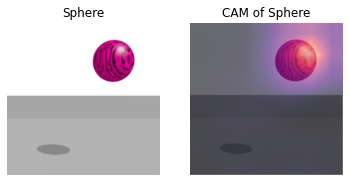

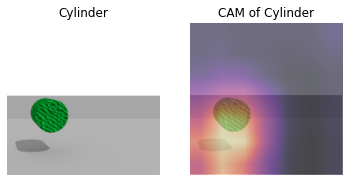

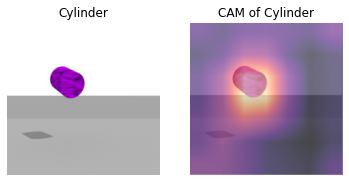

In [ ]:
for idx in range(3):
    visualize_cnn_by_cam(learner, idx)

Here are some items the model didn't do so well on, and the gradient cameras that give us some indication why.

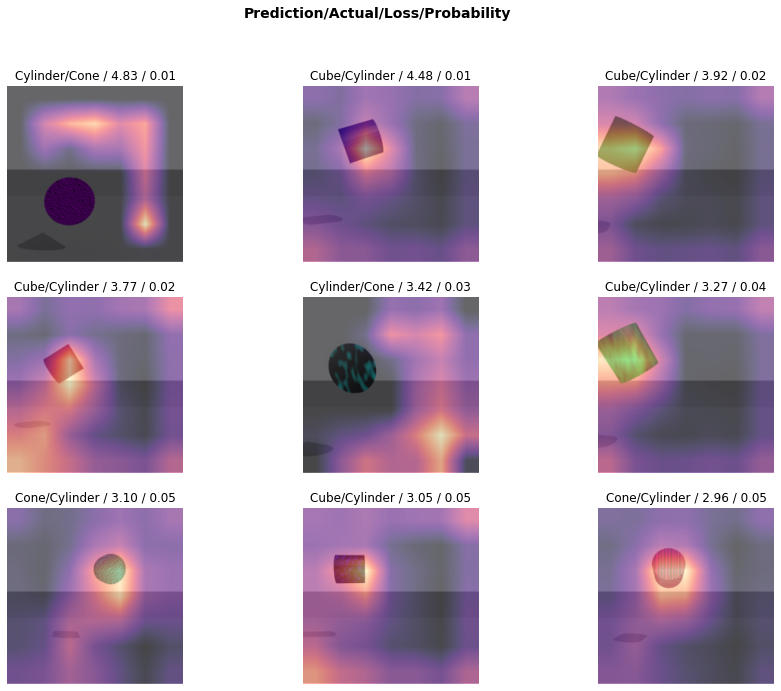

In [ ]:
# this creates an interpretation object, from which you can extract some useful performance stats
interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_top_losses(9, figsize=(15,11), heatmap=True)

Finally, we can look at the model's confusion matrix, a visualization that tells us which items the model most often confused. In our case, it appears the cylinder was the most commonly confused object (swapped semifrequently as it was with the cone and cube).

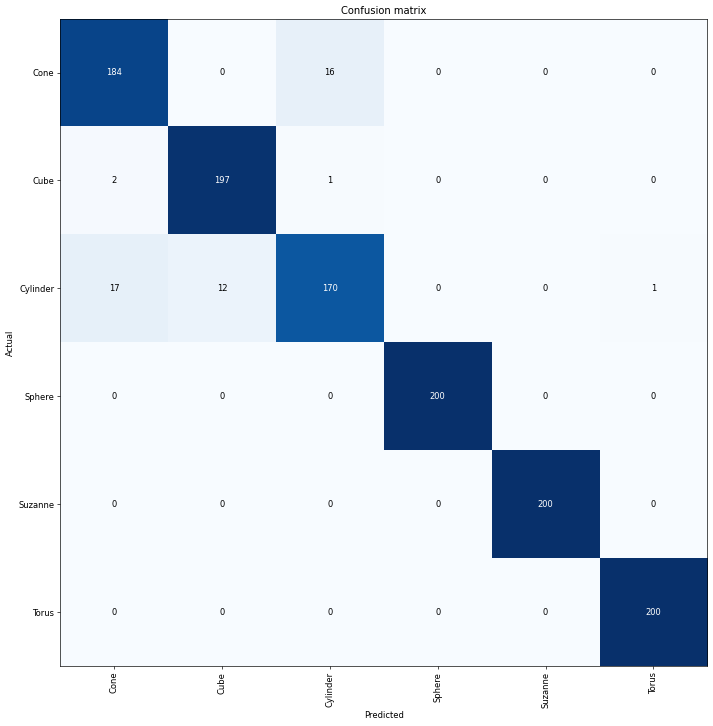

In [ ]:
interpretation.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
!pip install --quiet git+https://github.com/greentfrapp/lucent

     |████████████████████████████████| 225 kB 14.6 MB/s 
     |████████████████████████████████| 209 kB 69.1 MB/s 
     |████████████████████████████████| 297 kB 68.8 MB/s 
     |████████████████████████████████| 297 kB 71.3 MB/s 
     |████████████████████████████████| 297 kB 77.2 MB/s 
     |████████████████████████████████| 296 kB 77.8 MB/s 
     |████████████████████████████████| 296 kB 79.4 MB/s 
     |████████████████████████████████| 280 kB 78.2 MB/s 
     |████████████████████████████████| 280 kB 79.3 MB/s 
     |████████████████████████████████| 280 kB 76.8 MB/s 
     |████████████████████████████████| 280 kB 76.2 MB/s 
     |████████████████████████████████| 279 kB 11.6 MB/s 
     |████████████████████████████████| 279 kB 76.3 MB/s 
     |████████████████████████████████| 272 kB 79.6 MB/s 
     |████████████████████████████████| 272 kB 79.6 MB/s 
     |████████████████████████████████| 272 kB 79.2 MB/s 
     |████████████████████████████████| 270 kB 80.1 MB/s 
     |████████

In [ ]:
from lucent.optvis import render

In [ ]:
learner.data.classes #class labels

['Cone', 'Cube', 'Cylinder', 'Sphere', 'Suzanne', 'Torus']

100%|██████████| 512/512 [00:09<00:00, 55.63it/s]



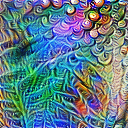

In [ ]:
# to render the visualization, we need the right feature (neuron) indicator
# in this case, that indicator is simply 'labels:label_number'
render.render_vis(learner.model, "labels:1", show_inline = True);

With our visualizations steps complete, let's save our transfer learning model to a new variable for later use:

In [ ]:
# return model to cpu to save memory
learner.model = learner.model.cpu();

# notice the model in learner is just a pytorch model
resnet_classifier = learner.model

### Transfer Learning in Base PyTorch

The abstraction of fastai is of course not for everyone. Below is an example of finetuning in pure PyTorch (adapted from the following official PyTorch tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

In [ ]:
import os, sys, copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

Below, we create a custom datasets that manages the feeding of our images and labels in batches to the algorithm. The key to the dataloader is to have a ```__getitem()__``` function and a ```__len()__``` function. The```__getitem()__``` function is often where you'll apply various image transforms before outputting the image and label together as a tuple. Here, we make a custom dataset that reads items from our dataframe.

In [ ]:
# our CustomDataset inherits its class structure from torch's Dataset
class CustomDataset(Dataset):
    def __init__(self, image_df, partition, image_transforms=None):
        # here we define whether the images sampled come are for training or eval:
        if partition == 'train':
            image_df = image_df.query('val_set == False').reset_index()
        if partition == 'val':
            image_df = image_df.query('val_set == True').reset_index()

        # we then save our image paths to a vector
        self.images = 'SimpleShapes/' + image_df['image_name']

        # this variable saves the names of our labels
        self.classes = image_df['label'].unique()

        # here, we transform our labels into integers
        self.labels = pd.Categorical(image_df['label']).codes

        # finally, we define our image transforms
        self.transforms = image_transforms

    def __getitem__(self, index):
        # in the arguments below, index refers to a row of our dataframe
        # to actually load an image we use PIL, converting the image to RGB
        img = PIL.Image.open(self.images[index]).convert('RGB')
        label = self.labels[index]

        # if we have transforms, we apply them here:
        if self.transforms:
            img = self.transforms(img)

        # finally, we return our img and label as a tuple
        return img, label

    # a convenience function to get the number of items in the dataset
    def __len__(self):
        return self.images.shape[0]

We then turn this custom dataset into two dataloaders, one for our training set and one for our testing set. The image transforms we use correspond to the original transforms used when training our pretrained model on ImageNet. We might, in addition, specify a few 'data augmentations' to increase our transfer learned model's robustness.

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224), # data augmentation 1
        transforms.RandomHorizontalFlip(), # data augmentation 2
        #homework: try adding to these augmentations: https://pytorch.org/vision/stable/transforms.html
        transforms.ToTensor(), # convert from PIL Image to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalize using ImageNet stats
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataloaders = {x: DataLoader(CustomDataset(label_df, x, data_transforms['train']), batch_size=64,
                             shuffle=True, num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

class_names = dataloaders['train'].dataset.classes

We then define our model training function, which cycles through our image batches, updating our weights with respect to our loss (in the training phase) or evaluating how well our updated model did on our held out set of images (in the validation phase).

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=3):
    best_model_wts = copy.deepcopy(model.state_dict()) #initialize a variable to hold the best model weights across epoch
    best_acc = 0.0 # initialize a variable to track the best accuracy across epochs

    model.to(device) #place model on gpu, if available

    iterator = tqdm(range(num_epochs))
    for epoch in iterator:

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # initialize variables to track stats
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out any previously calculated gradients
                optimizer.zero_grad()

                # make a forward pass through the network
                # use the loss to update weights only if training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward pass + update parameters only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                #update learning rate
                scheduler.step()

            # update our records of loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # deep copy the model if it's the best one so far:
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    print('Best Validation Accuracy: {:4f}'.format(best_acc))

    # load best model weights from those stored across the epochs
    model.load_state_dict(best_model_wts)
    model.to('cpu') # return model to cpu
    return model

In [ ]:
# load our pretrained model from torchvision
model = models.resnet18(pretrained=True)

# here, we redefine the final classification layer, taking its input features
# and resizing its output to be the number of classes in our dataset
model.fc = nn.Linear(model.fc.in_features, len(class_names))

# our loss function:
criterion = nn.CrossEntropyLoss()

# select optimizer for backpropagating errors
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Specify one cycle policy learning rate scheduler
one_cycle_scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=1e-01, steps_per_epoch=len(dataloaders['train']), epochs=3)

# freeze all layers that are not the fully-connected
# or batch-normalization layers
for name, param in model.named_parameters():
  if not 'bn' in name and not 'fc' in name:
    param.requires_grad = False

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = train_model(model, criterion, optimizer, one_cycle_scheduler, num_epochs=3)

  0%|          | 0/3 [00:00<?, ?it/s]

Best Validation Accuracy: 0.859167


Make sure once you're done with training and inference to return the model to the CPU to preserve GPU memory.

In [ ]:
model = model.cpu()

### The Variational Autoencoder

So far, we've used only supervised learning (transfer learning for image classification). To get a sense of unsupervised learning, here we'll introduce what's called a variational autoencoder. An autoencoder is an algorithm that takes some input, compresses it down to a lower-dimensional, "latent" space, then reinflates it back it to its original input. It learns by computing a loss between the original input and the reconstructed input, then adjusting its weights to minimize that loss.

A variational autoencoder is an autoencoder in which the latent space is no longer just a collection of points corresponding to inputs, but a collection of distributions corresponding to the mean and variance of inputs -- a probabilistic space. Because the space is probabilistic, it allows us to sample from the model and reconstruct images that don't exist in our training set. A variational autoencoder is thus an example of what's called a generative model.

In [ ]:
#@title Run this cell to load the autoencoder architecture.

# this code is based heavily on the following github repo:
# https://github.com/nadavbh12/VQ-VAE/blob/master/vq_vae/auto_encoder.py

import abc
import torch
from torch import nn
from torch.nn import functional
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision.models


class AbstractAutoEncoder(nn.Module):
    __metaclass__ = abc.ABCMeta

    @abc.abstractmethod
    def encode(self, x):
        return

    @abc.abstractmethod
    def decode(self, z):
        return

    @abc.abstractmethod
    def forward(self, x):
        """model return (reconstructed_x, *)"""
        return

    @abc.abstractmethod
    def sample(self, size):
        """sample new images from model"""
        return

    @abc.abstractmethod
    def loss_function(self, **kwargs):
        """accepts (original images, *) where * is the same as returned from forward()"""
        return

    @abc.abstractmethod
    def latest_losses(self):
        """returns the latest losses in a dictionary. Useful for logging."""
        return

class ResBlock(nn.Module):
    def __init__(self, in_channels, channels, bn=False):
        super(ResBlock, self).__init__()

        layers = [
            nn.ReLU(),
            nn.Conv2d(in_channels, channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels, channels, kernel_size=1, stride=1, padding=0)]
        if bn:
            layers.insert(2, nn.BatchNorm2d(channels))
        self.convs = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.convs(x)

#Adversarial Convolutional Variational Autoencoder
class ACVAE(AbstractAutoEncoder):
    def __init__(self, input_shape, input_channels=3, latent_dim=128, **kwargs):
        super(ACVAE, self).__init__()

        print("Adversarial VAE Model with Resnet Encoder & Latent Space of Size ", latent_dim)

        features = torchvision.models.resnet18(pretrained=True)
        self.encoder=nn.Sequential(*(list(features.children())[:-2]))

        self.decoder = nn.Sequential(
            ResBlock(input_shape, input_shape, bn=True),
            nn.BatchNorm2d(input_shape),
            ResBlock(input_shape, input_shape, bn=True),
            nn.BatchNorm2d(input_shape),

            nn.ConvTranspose2d(input_shape, input_shape, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_shape),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(input_shape, input_shape // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_shape//2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(input_shape // 2, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(16, input_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(input_channels, input_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(input_channels),
        )

        self.input_shape = input_shape
        #25088 corresponds to the flattened dimensions of the last conv layer of Resnet18
        self.fc_mu = nn.Linear(25088,latent_dim)
        self.fc_std = nn.Linear(25088,latent_dim)
        self.fc_z = nn.Linear(latent_dim,input_shape*4**2)

        self.mse = 0

    def encode(self, x):
        h1 = self.encoder(x)
        h1 = h1.view(-1, 25088)
        return self.fc_mu(h1), self.fc_std(h1)

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = Variable(std.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def decode(self, z):
        z=self.fc_z(z)
        z = z.view(-1, self.input_shape, 4, 4)
        h3 = self.decoder(z)
        return torch.tanh(h3)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        self.mu, self.logvar = mu, logvar
        return self.decode(z)#, mu, logvar

    def get_latent(self,x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return z

    def sample(self, size):
        sample = Variable(torch.randn(size, 128), requires_grad=False)
        if self.cuda():
            sample = sample.cuda()
        return self.decode(sample).cpu()

    def loss_function(self, x, recon_x):
        self.mse = F.mse_loss(recon_x, x)
        self.kl_loss = -0.5 * torch.sum(1 + self.logvar - self.mu.pow(2) - self.logvar.exp())
        self.kl_loss /= x.size(0) * 3 * 1024
        return 0.5 * self.mse + 1.0 * self.kl_loss

    def latest_losses(self):
        return {'mse': self.mse}

The dataset we've been working with so far is only 6000 images. For transfer learning on a well-behaved dataset, that tends to be sufficient. But for other purposes (like training our autoencoder) we'll need a bit more. So let's crank it up to 28,000 images.

In [ ]:
!gdown https://drive.google.com/uc?id=1aHzog-HB5J2XUH4U32Kw7ioYPrF-jHAy
!tar xf more_simple_shapes.tar.bz

Downloading...
From: https://drive.google.com/uc?id=1aHzog-HB5J2XUH4U32Kw7ioYPrF-jHAy
To: /content/more_simple_shapes.tar.bz
100% 82.8M/82.8M [00:01<00:00, 80.7MB/s]


We'll use almost the same method as before to construct a dataframe our dataloader can be built on.

In [ ]:
image_path = 'more_simple_shapes'
assets = glob(f'{image_path}/*.jpg')
dictlist = []
label_counts = {}
for asset in assets:
    imgstr = asset.split('/')[1]
    index = imgstr[:5]
    label = imgstr[5:imgstr.rfind('.')]
    if label not in label_counts:
        label_counts[label] = 0
    label_counts[label] += 1
    if label_counts[label] <= 4800:
        val_set = 0 if label_counts[label] <= 4500 else 1
        row = {'image_name': imgstr, 'image_index': index, 'label': label, 'val_set': val_set}
        dictlist.append(row)
label_df = pd.DataFrame(dictlist)

print('Proportion of Labels in Training / Eval')
print(label_df.groupby(['val_set'])['label'].value_counts())

Proportion of Labels in Training / Eval
val_set  label   
0        Cone        4500
         Cube        4500
         Cylinder    4500
         Sphere      4500
         Suzanne     4500
         Torus       4500
1        Cone         300
         Cube         300
         Cylinder     300
         Sphere       300
         Suzanne      300
         Torus        300
Name: label, dtype: int64


Once again, we establish a dataloader. This time, though, our target output is simply the input itself.

In [ ]:
data = (ImageImageList.from_df(label_df, Path(image_path), cols='image_name') # specify the column with the image names
            .split_from_df(col='val_set') # specify the column that splits the training / val sets
            .label_from_func(lambda x: x) # notice! the label for our image is the image itself
            .transform(size = 224, tfm_y = True) # apply a resize transform
            .databunch(bs=48)).normalize(imagenet_stats) # define batch size and normalize with imagenet statistics

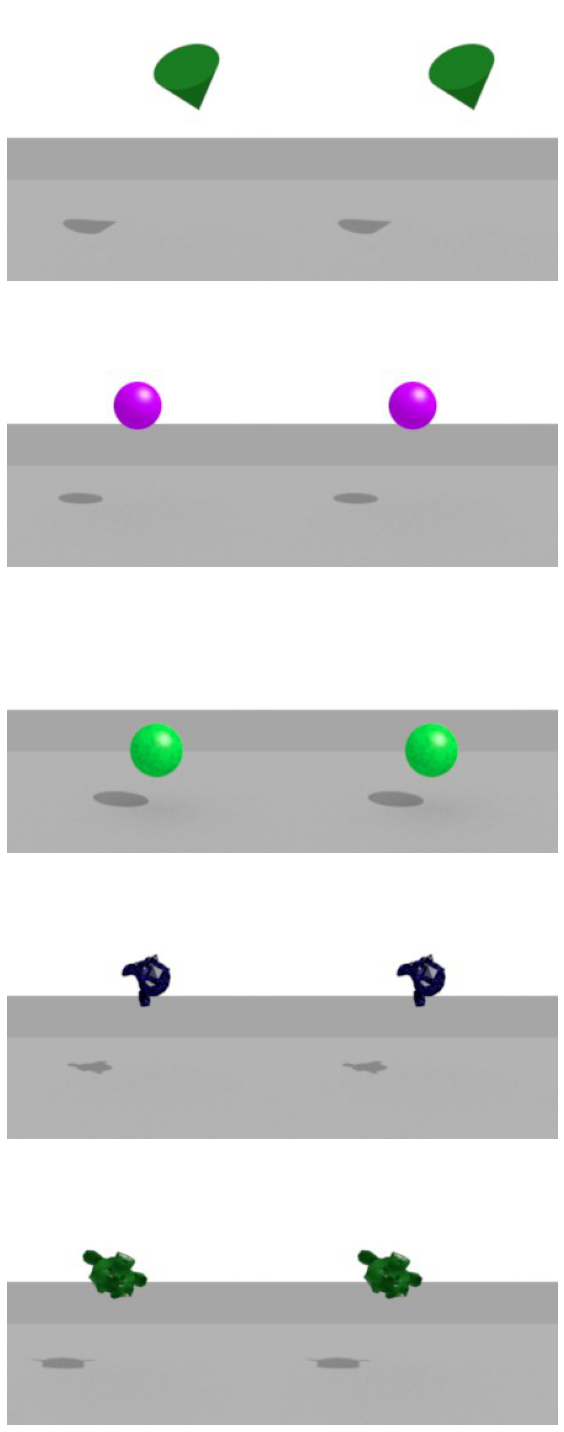

In [ ]:
data.show_batch()

Once we call our model, we can wrap a ```Learner``` object around, being sure to tell the model we want to use a custom loss function more appropriate to the variational autoencoder.

In [ ]:
vae = ACVAE(224, input_channels=3) # first, we instantiate our vae model

# we then pass this to a fastai learner object to facilitate training
# reference: https://towardsdatascience.com/autoencoders-in-the-fastai-library-fa288e1f899a
learner = Learner(data, vae, opt_func=torch.optim.Adam, loss_func=vae.loss_function)

# notice in fastai that our custom model is stored directly in the learner object
# vae == learn.model evaluates to True

Adversarial VAE Model with Resnet Encoder & Latent Space of Size  128


Let's give it a round of training. For the purposes of demonstration, I've set the default here to one epoch. To get anything meaningful, you'll need quite a few more.

In [ ]:
learner.fit_one_cycle(1, max_lr = 1e-4)

epoch,train_loss,valid_loss,time
0,0.264526,0.256257,01:46


Because our variational autoencoder is generative, once it's trained, we can create new samples by passing random values into the latent space (the space of maximal compression), and decoding the resultant images, which we then can visualize:

In [ ]:
sample = torch.randn(64, 128).cuda() # generate random array of values in the size of (n_samples, n_latent_dims)
sample = vae.decode(sample).detach().cpu() # pass this random array through the vae decode() function

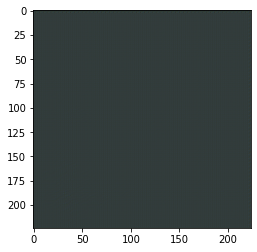

In [ ]:
plt.imshow(sample[0].permute(1, 2, 0));

(Clearly the model hasn't learned much of anything, yet... Let's pretend we trained this for a full cycle, and load a pretrained version.)

In [ ]:
!gdown https://drive.google.com/uc?id=1DfxSVNz2N8m5Jys52F3jqBX5olffEfYy

Downloading...
From: https://drive.google.com/uc?id=1DfxSVNz2N8m5Jys52F3jqBX5olffEfYy
To: /content/shape_central_acvae.pth
100% 80.0M/80.0M [00:00<00:00, 97.5MB/s]


In [ ]:
# load a slightly more trained version of the same vae
vae.load_state_dict(torch.load('shape_central_acvae.pth'))

<All keys matched successfully>

We can also create a full grid of samples:

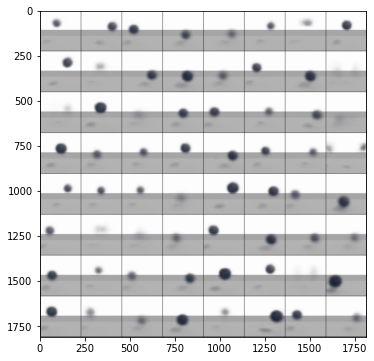

In [ ]:
from torchvision.utils import make_grid

#extract another sample of images:
sample = torch.randn(64, 128).cuda()
sample = vae.decode(sample).detach().cpu()

# plot image samples in a grid
fig, ax = plt.subplots(figsize=(18,6))
plt.imshow(sample[0].permute(1, 2, 0));
plt.imshow(make_grid(sample).permute(1,2,0));

We can, of course, also check the autoencoder's performance on one of its training images, assessing the reconstruction visually:

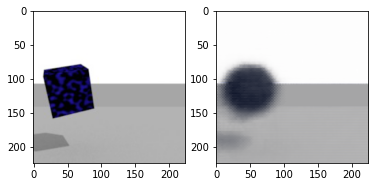

In [ ]:
import torchvision.transforms as transforms
import matplotlib.image as mpimg

# Relevant Transforms
image_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

probe_img = 'more_simple_shapes/00001Cube.jpg';

# apply transforms to image and place on gpu if applicable
img_tensor = image_transforms(PIL.Image.open(probe_img)).unsqueeze(0)
if next(vae.parameters()).is_cuda:
    img_tensor = img_tensor.cuda()

# pass image through the get_latent() function of vae and decode()
sample = vae.decode(vae.get_latent(img_tensor)).detach().cpu()

# plot original and reconstructed side by side
fig, ax = plt.subplots(1,2)
ax[0].imshow(mpimg.imread(probe_img));
ax[1].imshow(sample[0].permute(1, 2, 0));

Notice that while the autoencoder has done a pretty good job of reconstructing the object's position, it's maintained neither it's shape nor it's texture. It's possible this could be solved with more training examples, but it also could be that there's not enough regularity of shape and texture for the model to learn efficient representations thereof.

This sense of efficiency links to the concept of 'disentanglement', where different properties of objects are represented smoothly and distinctly in different parts of a generative model's latent space. Below, we'll attempt to see whether or not the item identities have been 'disentangled' with a dimensionality reduction and visualize technique called tsne, which attempts to project the many dimensions of variance in the latent space (128) down to the 2 or 3 dimensions that allow for plotting.

In [ ]:
n_embeddings = 1000
embeddings = []
embedding_labels = []

vae = vae.cuda()
for index, row in tqdm(label_df.sample(1000).iterrows(), leave=False, total = 1000):
    image, label = row['image_name'], row['label']
    img_tensor = image_transforms(PIL.Image.open(f'{image_path}/{image}')).unsqueeze(0).cuda()
    embedding = vae.get_latent(img_tensor).detach().cpu().numpy().squeeze()
    embeddings.append(embedding); embedding_labels.append(label)

  0%|          | 0/1000 [00:00<?, ?it/s]

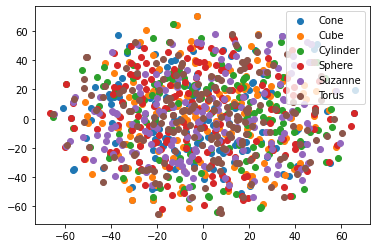

In [ ]:
from sklearn import manifold

tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=5)
tsne_data_points = tsne.fit_transform(np.stack(embeddings))

fig, ax = plt.subplots()
groups = pd.DataFrame(tsne_data_points, columns=['x', 'y']).assign(category=np.stack(embedding_labels)).groupby('category')
[ax.scatter(points.x, points.y, label=name) for name, points in groups]
ax.legend();

As we can see, our autoencoder hasn't necessarily disentangled the identities of our objects in any meaningful way. It remains to be seen whether more data (or more regular data) could contribute to a more meaningful disentanglement.

Let's return our model to the cpu and store it for later use.

In [ ]:
resnet_autoencoder = learner.model.encoder
learner.model = learner.model.cpu()

## Deep Learning on Natural Language Data

Images, of course, aren't the only thing neural networks are good for. Equally titanic in the field of machine learning is natural language processing -- learning done on text.

Deep learning's particular edge on NLP is generative; by learning the statistics of linguistic input, deep NLP algorithms are often able to produce new samples of text that cohere with the formalisms (semantic and syntactical) of natural language.

Using the internet as one massive linguistic corpus, modern deep NLP algorithms have made massive strides with massive models. So massive are these models, and so constrained is the space of natural language, that it's almost never the case you'll be training a deep learning NLP model from scratch. Here, then, we'll cover two examples of transfer learning on pretrained transformers -- now the most popular model in natural language processing.

By and large the most useful toolkit for this is that of [huggingface](https://huggingface.co/) -- a strangely named, but incredibly powerful framework for natural language processing, complete with a comprehensive repository of pretrained models and a large number of readily available datasets.

### Transfer Learning for Stylized Text Generation

Want to write text in the style of your favorite author? Take a pretrained transformer and condition its output by finetuning on the corpus of your choice.

Below, we'll try to emulate the writing of Harvard psychologist William James (affectionately known as Billy Jim) by finetuning GPT2 (OpenAI's flagship transformer model) on the book "Principles of Psychology" (1890).

This tutorial was inspired by: http://education.abcom.com/using-gpt-2-to-write-like-shakespeare/ and https://huggingface.co/blog/how-to-generate ...
and takes advantage of Huggingface's updated [language modeling](https://github.com/huggingface/transformers/tree/master/examples/language-modeling) process.

In [ ]:
# first we pip install the most recent huggingface repo from github
!pip install -q git+https://github.com/huggingface/transformers/
!pip install -q git+https://github.com/huggingface/datasets/

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 15.5 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 596 kB 67.5 MB/s 
     |████████████████████████████████| 212 kB 15.8 MB/s 
     |████████████████████████████████| 115 kB 73.8 MB/s 
     |████████████████████████████████| 141 kB 72.3 MB/s 
     |████████████████████████████████| 127 kB 77.3 MB/s 


In [ ]:
# here we download a python script for finetuning, and the a .txt file containing the text from "Principles of Psychology"
!wget https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/run_clm.py
!gdown https://drive.google.com/uc?id=1TXK_cYyCxNaOp6SbEpL0X-3MF_vQJvVn

--2022-08-09 15:12:53--  https://raw.githubusercontent.com/huggingface/transformers/master/examples/pytorch/language-modeling/run_clm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25029 (24K) [text/plain]
Saving to: ‘run_clm.py’

run_clm.py          100%[===================>]  24.44K  --.-KB/s    in 0s      

2022-08-09 15:12:53 (137 MB/s) - ‘run_clm.py’ saved [25029/25029]

Downloading...
From: https://drive.google.com/uc?id=1TXK_cYyCxNaOp6SbEpL0X-3MF_vQJvVn
To: /content/billy_jim_psych.txt
100% 228k/228k [00:00<00:00, 104MB/s]


Huggingface effectively automates this process of finetuning with a dedicated python script, asking only for an output directory and an input (either a text file, passed with the argument *--train_file* or a registered dataset, passed with the argument *--dataset_name*).

In [ ]:
!pip install -q evaluate
!mkdir nlp_models

     |████████████████████████████████| 69 kB 6.7 MB/s 


In [ ]:
%%capture

!python run_clm.py \
    --model_name_or_path gpt2 \
    --train_file '/content/billy_jim_psych.txt' \
    --do_train \
    --output_dir nlp_models/ \
    --overwrite_output_dir \
    --per_device_train_batch_size 2

Once we've finetuned the weights of our GPT transformer, we can load and play with it accordingly. Huggingface includes model-appropriate tools for tokenizing inputs and detokenizing outputs that make it easy to feed plain text of choice directly into the model. (Tokenizing is a step in natural language processing that transforms text and symbols into integers).


In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('nlp_models/') # instantiate our gpt2 tokenizer
model = GPT2LMHeadModel.from_pretrained('nlp_models/', pad_token_id=tokenizer.eos_token_id) # instantiate our model...
# ... additionally specifying tokens that pad our input (tokens like the end of sentence [EOS] token here)

To generate new samples of Billy Jim text, we provide our finetuned model with a prompt. Here we'll use Billy's Jim's theory of the provenance of fear (that fear is our cognitive interpretation of negative physiological arousal).

In [ ]:
# encode our prompt sentence, specifying that the tokens should be returned in PyTorch ('pt')
ids = tokenizer.encode('First comes the physiology, then the fear.', return_tensors='pt')

# pass our encoded prompt through the model and sample from the space of subsequent predictions
sample_output = model.generate(ids, do_sample=True, max_length=150, top_k=50, top_p = 0.90, temperature = 1.0)
# k defines the k most likely tokens to filter from the prediction
# p defines the cumulative probability threshold of tokens to filter from the prediction
# temperature is a measure of how wild we're allowing our predictions to be

# finally, pass the output of the model back through our tokenizer to return actual text
decoded_output = tokenizer.decode(sample_output[0], skip_special_tokens=True)

In [ ]:
from textwrap import TextWrapper as wrap_text
[print(el) for el in wrap_text(width = 100).wrap(decoded_output + '...')][0]

First comes the physiology, then the fear. All three are connected in one thing:   A fear, which is
the fear of one thing;  Fear, which is the fear of another thing.  If we have a feeling that
anything is wrong, or that the way it has been done is wrong, and yet fear it is, we may feel a
feeling in the opposite direction; but if we have a feeling of danger, that same feeling can only
have a feeling in the opposite direction.  And a thing that we have felt is not the same thing that
a thing which we have felt is, for we may feel that whatever we have said is true but that it is
something which we may not have done for...


### Transfer learning for Text Classification

Stylized text generation is not the only thing we can extract from the learned reprsentations of a pretrained transformer. Another option is to use these representations as the basis of other tasks, like classification and sentiment analysis.

Here, we'll use the representations of another popular transformer (BERT) as a basis for classifying sarcasm. This tutorial is adapted almost line by line from a different tutorial on classifying linguistic acceptability: https://towardsdatascience.com/sentence-correctness-classifier-using-transfer-learning-with-huggingface-bert-8884795ba5ca

First, we download and process our dataset -- taking care to properly tokenize and pad our inputs to fit the model. (Padding is a process whereby inputs of a certain length are 'padded' to acheive consistent input lengths. For example, if our input length is 64 and we have an input of length 37, we pad that input with 27 tokens, and tell the model to 'ignore' them with an attention mask.)

In [ ]:
# sarcasm detection from kaggle: https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection
!gdown https://drive.google.com/uc?id=1PC1s-I34xQaiAvwUTDmA-yG2WNEzbiP9
!unzip sarcasm_detection.zip

Downloading...
From: https://drive.google.com/uc?id=1PC1s-I34xQaiAvwUTDmA-yG2WNEzbiP9
To: /content/sarcasm_detection.zip
100% 3.46M/3.46M [00:00<00:00, 102MB/s]
Archive:  sarcasm_detection.zip
  inflating: Sarcasm_Headlines_Dataset.json  
  inflating: Sarcasm_Headlines_Dataset_v2.json  


In [ ]:
import os, sys
import pandas as pd
from tqdm.auto import tqdm

In [ ]:
# Load the dataset into a pandas dataframe.
df = pd.read_json("Sarcasm_Headlines_Dataset_v2.json", lines = True).drop('article_link', axis =1)
df = df.rename(columns={'is_sarcastic':'label', 'headline':'sentence'})

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 5 random rows from the data.
df.sample(5)

Number of training sentences: 28,619



,label,sentence
3715,0,how synagogues honor non-jewish congregants on...
28203,0,g20 leaders must turn the tide on inequality a...
19938,0,seahawks player hugs ref after fumble-return t...
9604,1,alpha male marries tri-delta female
14799,0,the internet and social media: how to disconnect


In [ ]:
for sample_sentence in df.sample(5).sentence:
  print(sample_sentence)

the bravery of transgender service members rejuvenates the sense of service this veteran's day
coroner's report: john denver had sunshine on shoulders at time of crash
defense department layoffs result in increased video rentals
making a living ... and a loving
state of the union preceded by memoriam reel of americans lost in past year


In [ ]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [ ]:
# here, we instantiate our tokenizer
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Here, we loop through the sentences in our dataset and find the sentence with the greatest length. Following convention, we then choose the nearest multiple of 32 (32, 64, 96) as our designated input length.

In [ ]:
max_length = 0

# For every sentence...
for sentence in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sentence, add_special_tokens=True)

    # Update the maximum sentence length.
    max_length = max(max_length, len(input_ids))

print('Max sentence length: ', max_length)

Max sentence length:  193


Now, we make our sentences transformer readable.

In [ ]:
import torch
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sentence in tqdm(sentences):
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(sentence, # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 256,           # Pad & truncate all sentences.
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt')    # Return pytorch tensors.

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])
print('Attention Masks: ', attention_masks[0])

  0%|          | 0/28619 [00:00<?, ?it/s]

Original:  thirtysomething scientists unveil doomsday clock of hair loss
Token IDs: tensor([  101,  4228, 14045, 20744,  6529,  4895,  3726,  4014, 12677, 16150,
         4710,  5119,  1997,  2606,  3279,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,  

Having transformed our data into the right format, we can now proceed with a standard analytic pipeline for classification, splitting our sample into train and test sets, instantiating our dataloaders, defining loss, optimizers and scheduling, then finally training our model and evaluating its accuracy.

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

25,757 training samples
2,862 validation samples


Also check for bias in terms of the relative number of positive versus negative samples in your training set!

In [ ]:
df.iloc[train_dataset.indices]['label'].value_counts()

0    13476
1    12281
Name: label, dtype: int64

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 16
train_dataloader = DataLoader(train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size) # Trains with this batch size.


validation_dataloader = DataLoader(val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size) # Evaluate with this batch size.

In [ ]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
        num_labels = 2, # The sentence is either gramatically correct (1) or incorrect (0)
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False) # Whether the model returns all hidden-states.

num_epochs = 3
learning_rate = 3e-5

optimizer = AdamW(model.parameters(), lr = learning_rate, eps = 1e-3)

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * num_epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# a function to take the raw outputs of our model
# and translate them to a measure of accuracy
def compute_accuracy(logits, labels):
  _, preds = torch.max(logits, 1)
  return(torch.sum(preds == labels).item())

def train_model(model, optimizer, scheduler, num_epochs=3):
  model.to(device)

  for epoch in tqdm(range(0, num_epochs), desc = 'Epoch'):
    total_train_loss = 0 # variable to track loss in training
    model.train()

    for step, batch in enumerate(tqdm(train_dataloader, leave=False, desc = 'Training')):
      # batch contains three pytorch tensors:
      batch_input_ids = batch[0].to(device) #input ids
      batch_input_mask = batch[1].to(device) #attention masks
      batch_labels = batch[2].to(device) #labels

      # zero out any previously calculated gradients
      model.zero_grad()

      # the forward pass of our model, which takes each element of our batcch
      outputs = model(batch_input_ids, token_type_ids=None,
                          attention_mask=batch_input_mask, labels=batch_labels)
      # the variable outputs holds two values:
      # the loss (between predicted and actual labels)
      # the logits (predicted probabilities of labels)

      # backward pass to calculate gradients
      outputs.loss.backward()

      #append the loss to a running calculation
      total_train_loss += outputs.loss.item()

      # clip the gradients to prevent gradient explosion
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # update parameters
      optimizer.step()

      # update learning rate
      scheduler.step()

    # calculate the average training loss across batches
    avg_train_loss = total_train_loss / len(train_dataloader)
    print("Average Training Loss: {0:.2f}".format(avg_train_loss))

    model = model.eval() # place model in eval mode

    # tracking stats for eval
    total_eval_loss = 0
    total_eval_correct = 0

    # Evaluate data for one epoch
    for batch in tqdm(validation_dataloader, leave=False, desc = 'Validating'):
      batch_input_ids = batch[0].to(device)
      batch_input_mask = batch[1].to(device)
      batch_labels = batch[2].to(device)

      # ensure no calculation of gradients
      with torch.no_grad():
        outputs = model(batch_input_ids, token_type_ids=None,
                        attention_mask=batch_input_mask, labels=batch_labels)

      # update tracking stats with loss and accuracy
      total_eval_loss += outputs.loss.item()
      total_eval_correct += compute_accuracy(outputs.logits, batch_labels)

    avg_eval_loss = total_eval_loss / len(validation_dataloader)
    print('Average Validation Loss: {0:.2f}'.format(avg_eval_loss))

    validation_acc = total_eval_correct / len(validation_dataloader.dataset)
    print("Validation Accuracy: {0:.2f}".format(validation_acc))

  model.to('cpu')
  return model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = train_model(model, optimizer, scheduler, num_epochs = 1)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/1610 [00:00<?, ?it/s]

Average Training Loss: 0.40


Validating:   0%|          | 0/179 [00:00<?, ?it/s]

Average Validation Loss: 0.26
Validation Accuracy: 0.90


We can now save the model for later use or inference.

In [ ]:
tokenizer.save_pretrained('pretrained_sarcastic_bert')
model.save_pretrained('pretrained_sarcastic_bert')

Want to query your trained model with your own prompts?

In [ ]:
# let's write a function to tokenize and convert a prompt into a prediction
def test_for_sarcasm(prompt):
  prompt_token = tokenizer.encode_plus(prompt, add_special_tokens = True,
                                  return_attention_mask = True, return_tensors = 'pt')

  output = model(prompt_token['input_ids'], token_type_ids=None,
                attention_mask=prompt_token['attention_mask'], labels=torch.tensor([1]))

  class_dict = {1: 'sarcastic', 0: 'straight'}
  return class_dict[torch.max(output.logits, 1).indices.item()]

In [ ]:
prompt = 'Capitol Stormed by Pro-Trump Rioters'
test_for_sarcasm(prompt)

'straight'

In [ ]:
prompt = 'Local Graduate Student Weeps on Keyboard, Again'
test_for_sarcasm(prompt)

'sarcastic'

We can also use a similar process to extract the responses of a given prompt, and visualize the weights of a target attention block.

In [ ]:
#we're loading our saved model, both for sanity's sake, but also
# to reinitialize so that we can extract attention features
tokenizer = BertTokenizer.from_pretrained('pretrained_sarcastic_bert', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained("pretrained_sarcastic_bert",
        num_labels = 2, output_attentions = True, output_hidden_states = True)

In [ ]:
prompt = 'Local Graduate Student Weeps on Keyboard, Again'
prompt_token = tokenizer.encode_plus(prompt, add_special_tokens = True,
                                     return_attention_mask = True, return_tensors = 'pt')

output = model(prompt_token['input_ids'], token_type_ids=None,
              attention_mask=prompt_token['attention_mask'], labels=torch.tensor([1]))

In [ ]:
!pip install -q bertviz

     |████████████████████████████████| 157 kB 16.1 MB/s 
     |████████████████████████████████| 132 kB 72.4 MB/s 
     |████████████████████████████████| 1.3 MB 73.5 MB/s 
     |████████████████████████████████| 79 kB 9.0 MB/s 
     |████████████████████████████████| 9.0 MB 56.1 MB/s 


In [ ]:
from bertviz import head_view

In [ ]:
prompt_token_list = tokenizer.convert_ids_to_tokens(prompt_token.input_ids[0].tolist())
head_view(output.attentions, prompt_token_list)

<IPython.core.display.Javascript object>